In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, UpSampling2D, Concatenate, Add
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adadelta
from matplotlib import pyplot as plt
import numpy as np

# Keras

## Sequential model

In [ ]:
# define the model
model = Sequential()
model.add(Input(shape=(100,)))
model.add(Dense(30))
model.add(Dense(10))
model.add(Dense(2))
tf.keras.utils.plot_model(model, show_shapes=True)

## Functional model

In [ ]:
# define the layers
x_in = Input(shape=(100,))
x = Dense(30)(x_in)
x = Dense(10)(x)
x_out = Dense(2)(x)
# define the model
model = Model(inputs=x_in, outputs=x_out)
tf.keras.utils.plot_model(model, show_shapes=True)

The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.


**Multiple inputs and outputs**

In [ ]:
# define the layers
# input branch 1
x_in_1 = Input(shape=(100,))
x_1 = Dense(30)(x_in_1)
# input branch 2
x_in_2 = Input(shape=(100,))
x_2 = Dense(30)(x_in_2)
# input branch 3
x_in_3 = Input(shape=(100,))
x_3 = Dense(30)(x_in_3)
# merge features of all 3 branches
x = Concatenate()([x_1, x_2, x_3])
# layer with concatenated features as input
x = Dense(10)(x)
# two outputs
x_out_1 = Dense(2)(x)
x_out_2 = Dense(2)(x)
# define the model with multiple inputs and outputs
model = Model(inputs=[x_in_1, x_in_2, x_in_3], outputs=[x_out_1, x_out_2])
tf.keras.utils.plot_model(model, show_shapes=True)

**Skip connection**

TODO - Create a model with skip connection like on image below. With skip connection, previous layer is summed with one of the previoius layers. Use Add layer provided by Keras. Skip connection used like this (residual block) allow for training deeper networks.

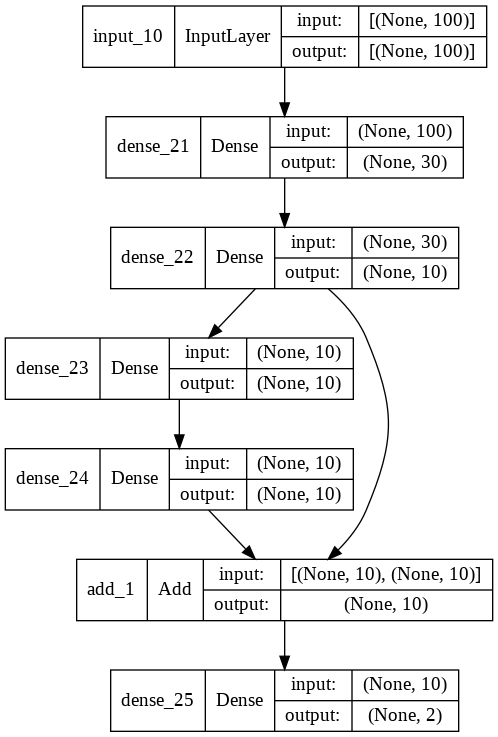

In [ ]:
# define the layers
x_in = Input(shape=(100,))
x_h1 = Dense(30)(x_in)
x_h2 = Dense(10)(x_h1)
x_h3 = Dense(10)(x_h2)
x_h4 = Dense(10)(x_h3)
x_add = Add()([x_h2, x_h4])
x_out = Dense(2)(x_add)
# define the model
model = Model(inputs=x_in, outputs=x_out)
tf.keras.utils.plot_model(model, show_shapes=True)

**Convolutional MNIST classifier**

Define the model

In [ ]:
input_img = Input(shape=(28, 28, 1)) # Image should have 3 dimensions, even grayscale
x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(input_img)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x_out = Dense(10, activation='softmax')(x)
model = Model(inputs=input_img, outputs=x_out)
tf.keras.utils.plot_model(model, show_shapes=True)

Compile the model

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

Load and preprocess data

In [ ]:
def load_mnist():
  # load
  mnist_dataset = mnist.load_data()
  (trainset, testset) = (mnist_dataset[0], mnist_dataset[1])
  (X_train, y_train) = trainset
  (X_test, y_test) = testset
  # preprocess
  X_train = X_train.astype('float32')
  X_train /= 255
  X_test = X_test.astype('float32')
  X_test /= 255
  # Add another dimension to the data to account for the channels, greyscale = 1 channel
  X_train = X_train[..., np.newaxis]
  X_test = X_test[..., np.newaxis]
  # labels
  y_train = tf.one_hot(y_train, depth=10)
  y_test = tf.one_hot(y_test, depth=10)
  return X_train, y_train, X_test, y_test

Visualise data

In [ ]:
def show_images(X, n_images=5):
  X_plot = np.squeeze(X)
  fig = plt.figure()
  for i in range(n_images):
    fig.add_subplot(1, n_images, i+1)
    plt.imshow(X_plot[i], cmap='gray')
  plt.show()


In [ ]:
X_train, y_train, X_test, y_test = load_mnist()
show_images(X_train, n_images=5)

Train the model

In [ ]:
history = model.fit(x=X_train, y=y_train, batch_size=256, epochs=10, validation_split=0.2)

In [ ]:
def plot_losses(history):
    losses = history.history
    plt.plot(losses['loss'], label='train loss')
    plt.plot(losses['val_loss'], label='val loss')
    plt.legend()
    plt.show()

In [ ]:
plot_losses(history)

Evaluate the model on test data

In [ ]:
model.evaluate(X_test, y_test)

**Convolutional MNIST autoencoder**

In [ ]:
#########
# Define the model here
#########
input_img = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8), i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

model = Model(inputs=input_img, outputs=decoded)

optimiser = Adadelta(learning_rate=1.0)

model.compile(optimizer=optimiser, loss='mean_squared_error')

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(x=X_train, y=X_train, batch_size=256, epochs=10,
                    validation_split=0.2, shuffle=True)

In [ ]:
plot_losses(history)

Reconstruct images from the test set

In [ ]:
n_images = 10
orig_images = X_test[:n_images]
decoded_images = model.predict(orig_images)

In [ ]:
show_images(orig_images, 5)

In [ ]:
show_images(decoded_images, 5)

If the model is not reconstructiong well, run the below command and train the model again.

In [ ]:
#del model
#tf.keras.backend.clear_session()

When you're satisfied with the performance of the model, you can save it on your Google Drive account.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
path = F"/content/gdrive/My Drive/ae_mnist.keras"

In [ ]:
model.save(path)

If you reconnect later, you can load the model with the following command.

In [ ]:
# model.load_weights(path)

**Train classifier on encoded data**

In Keras we build model as a graph of nodes. Multiple models can be defined on top of the same graph. We define the model by simply stating the starting and the ending node.

In [ ]:
encoder = Model(input_img, encoded)

In [ ]:
encoder.predict(orig_images).shape

TODO - Create and train classifier of encoded MNIST data with one softmax layer.

In [ ]:
cl_input = Input(shape=(4,4,8))
x = Flatten()(cl_input)
x_out = Dense(10, activation='softmax')(x)
cl_model = Model(cl_input, x_out)

In [ ]:
cl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
X_train_cl = encoder.predict(X_train)

In [ ]:
history = cl_model.fit(x=X_train_cl, y=y_train, batch_size=256, epochs=10, validation_split=0.2)

In [ ]:
plot_losses(history)

In [ ]:
cl_model.evaluate(encoder(X_test), y_test)

It is also possible to create a model containing both encoder and a classifier, so we can do predictions directly on raw MNIST images.

In [ ]:
ae_cl_out = cl_model(encoder(input_img))

In [ ]:
ae_classifier = Model(input_img, ae_cl_out)

In [ ]:
ae_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
ae_classifier.evaluate(X_test, y_test)

TODO - Generate data with decoder


*   Define decoder model on top of the existing autoencoder
*   Generate random data of the same size as encoded data
*   Pass generated data through the decoder and plot the output

Can decoder generate good quality data?




Define decoder

In [ ]:
decoder = Model(encoded, decoded)

Generate random data

In [ ]:
gen_inp = tf.random.normal(shape=(5,4,4,8))

Pass generated data through the decoder

In [ ]:
gen_out = decoder.predict(gen_inp)

Show reconstructions

In [ ]:
show_images(gen_out, 5)

For more on Functional API: https://keras.io/guides/functional_api/

# Tensorflow low-level

In [ ]:
cl_model.layers

Input to keras model is a tensor. Tensors are constants.

In [ ]:
cl_model.input

Weights of the model are tensor variables. Variables can change their value during training.

In [ ]:
cl_model.layers[2].weights

Create a tensor constant.

In [ ]:
x = tf.constant([[1., 2., 3.],
             [4., 5., 6.]])


In [ ]:
x

Tensors are immutable

In [ ]:
x[0][1] = 10

Various operations that you can do with tensors.

In [ ]:
x + x

In [ ]:
5 * x

In [ ]:
tf.transpose(x)

Matrix multiplication

In [ ]:
tf.matmul(x, tf.transpose(x))

Matrix multiplication shorter

In [ ]:
x @ tf.transpose(x)

In [ ]:
tf.reduce_sum(x)

Tensor that could be changed - variable. Variables are used for model weights.

In [ ]:
x = tf.Variable(1.0)

**Gradient tape - example #1**

In [ ]:
x = tf.Variable(1.0)

def f(x):
  y = x**2 + 2*x - 5
  return y

In [ ]:
f(x)


Calculate the gradient of f(x) with respect to x

In [ ]:
with tf.GradientTape() as tape:
  y = f(x)

g_x = tape.gradient(y, x)

In [ ]:
g_x

Perform a step of gradient descent - change x to minimize f(x).

In [ ]:
optimizer = tf.optimizers.SGD(learning_rate=0.01)
optimizer.apply_gradients(zip([g_x], [x]))


In [ ]:
x

In [ ]:
f(x)

**Gradient tape - example #2**

A step of gradient descent for multi-layer perceptron.

In [ ]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
  y = x @ w + b
  loss = tf.reduce_mean(y**2  )


In [ ]:
w

In [ ]:
b

In [ ]:
[dl_dw, dl_db] = tape.gradient(loss, [w, b])

In [ ]:
[dl_dw, dl_db]

In [ ]:
optimizer = tf.optimizers.SGD(learning_rate=0.01)
optimizer.apply_gradients(zip([dl_dw, dl_db], [w,b]))

In [ ]:
w

In [ ]:
b

TODO (optional, advanced) - Train multi-layer perceptron on MNIST flattened data for 10 steps using low-level Tensorflow.

When you need more than Keras can provide, you can mix TF and Keras:


*   Add TF operations to Keras models
*   Train Keras model using Gradient Tape and custom training loop instead of fit function
*   Define custom layers, loss functions, ...

